In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as anim 

In [2]:
positive = pd.read_csv('data/positive.tsv', sep='\t', index_col=0)
positive['target'] = 1
negative = pd.read_csv('data/negative.tsv', sep='\t', index_col=0)
negative['target'] = 0
data_raw = positive.append(negative)
target = data_raw.target.values

In [3]:
embedding = np.load('./embeddings/embed_articles_3.npy')

In [4]:
from sklearn.manifold import TSNE

red_dim_embed = np.empty([0, 14203, 2])

for x in embedding:
    X_2D = TSNE(n_components=2, perplexity=50, random_state=42).fit_transform(x)
    red_dim_embed = np.concatenate((red_dim_embed, X_2D[None, ...]), axis=0)

In [5]:
red_dim_embed.shape

(12, 14203, 2)

In [6]:
def intermediates(p1, p2, nb_points=8):
    """"Return a list of nb_points equally spaced points
    between p1 and p2"""
    # If we have 8 intermediate points, we have 8+1=9 spaces
    # between p1 and p2
    x_spacing = (p2[0] - p1[0]) / (nb_points + 1)
    y_spacing = (p2[1] - p1[1]) / (nb_points + 1)

    return np.array([[p1[0] + i * x_spacing, p1[1] +  i * y_spacing] 
            for i in range(0, nb_points+2)])[:, :, 0]

In [8]:
def frame_generator():
    for frame in range(1, 251):
        # Yield the frame first
        yield frame
        # If we should "sleep" here, yield None HOLD_COUNT times  
        if frame % 50 == 0:
            for _ in range(24):
                yield None

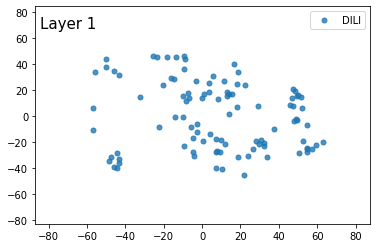

In [19]:
ax = plt.axes()

x, y = np.split(red_dim_embed, 2, axis=2)

paths = np.empty([0, 550, 2])
points = []
for x_cord, y_cord, targ in zip(np.rollaxis(x, 1), np.rollaxis(y, 1), target):
    [line] = ax.plot(x_cord, y_cord,
                 color='blue', linewidth=1,
                 alpha=0)
    if targ == 0:
        points.append(ax.plot(x_cord[0], y_cord[0], marker='o', color='tab:red', 
                              label='non-DILI', linestyle="None", alpha=0.8, ms=5)[0])
    elif targ == 1:
        points.append(ax.plot(x_cord[0], y_cord[0], marker='o', color='tab:blue', 
                              label='DILI', linestyle="None", alpha=0.8, ms=5)[0])

    verts = np.empty([0, 2])

    for n, val in enumerate(x_cord[:-1]):
        interim = intermediates([x_cord[n], y_cord[n]], [x_cord[n+1], y_cord[n+1]], nb_points=48)
        verts = np.append(verts, interim, axis=0)
    paths = np.append(paths, verts[None, ...], axis=0)


text = ax.text(0.015, 0.9, f'Layer {num}', fontsize=15,
              transform=ax.transAxes)

handles, labels = ax.get_legend_handles_labels()
i = 1
while i<len(labels):
    if labels[i] in labels[:i]:
        del(labels[i])
        del(handles[i])
    else:
        i +=1

ax.legend(handles, labels)

def animate(i, verts=paths, text=text):
    i = i % verts.shape[1]

    # Set the coordinates of the line to the coordinate of the path.
    for k in range(paths.shape[0]):
        points[k].set_data(verts[k, i, 0], verts[k, i, 1])

    # Update layer
    if i == 0:
        text.set_text('Layer 1')
    elif (i + 1) % 50 == 0:s
        text.set_text(f'Layer {int(((i + 1) / 50) + 1)}')
    
    return points

def init():
    return points
        
    
ani = anim.FuncAnimation(
    ax.figure, animate,
    init_func=init,
    frames= verts.shape[0],
    interval=5, repeat=False
)
    
plt.show()

writervideo = anim.FFMpegWriter(fps=24)
ani.save('point_ani.mp4', writer=writervideo, dpi=300)

# ani.save('point_ani.gif', writer='pillow', dpi=50)